In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import nltk
import nltk as nlp
import string
import re

In [2]:
import sys
!{sys.executable} -m pip install spacy

In [3]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

In [4]:
!{sys.executable} -m pip install psycopg2

In [6]:
import psycopg2
conn = psycopg2.connect(dbname='vknews', user='postgres', 
                        password='password', host='172.17.0.2')
cursor = conn.cursor()

In [7]:
cursor.execute('SELECT * FROM posts')
records = cursor.fetchall()
posts = list(records)
len(posts)

576

In [8]:
posts[0]

(4057308,
 'meduzaproject',
 datetime.datetime(2020, 6, 11, 20, 40, 10),
 'Редакция «Ведомостей» после смены владельцев издания предложила назначить Анфису Воронину главным редактором',
 'Редакция «Ведомостей» рекомендовала совету директоров АО «Бизнес ньюс медиа» (издатель газеты) назначить главным редактором издания Анфису Воронину.',
 47,
 32424,
 11,
 1)

In [9]:
title_list = [post[3] for post in posts]
text_list = [post[4] for post in posts]

In [10]:
!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator

In [11]:
def unique(text):
    for word in text:
        text = text.split()
        text = set(text)
        return text
unique("i am going and i will go by bus")

{'am', 'and', 'bus', 'by', 'go', 'going', 'i', 'will'}

In [12]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
remove_punct("wow!!!")

'wow'

In [13]:
news = pd.DataFrame(data={'title': title_list, 'text': text_list})
news

,title,text
0,Редакция «Ведомостей» после смены владельцев и...,Редакция «Ведомостей» рекомендовала совету дир...
1,Собянин попросил москвичей не ходить на парад ...,"Мэр Москвы Сергей Собянин заявил, что в День Р..."
2,Курс евро на Московской бирже поднялся выше 79...,Курс евро на торгах на Московской бирже поднял...
3,Хакеры взломали 300 тысяч учетных записей поль...,В результате хакерской атаки были похищены дан...
4,Бизнесмена из «списка Титова» вопреки обещания...,Хорошевский суд Москвы арестовал бывшего генди...
...,...,...
571,Что ждет туристов на Черном море,В Крыму начинается курортный сезон — сначала д...
572,В Алуште прокомментировали скандал с ошибкой в...,Работник городской администрации крымской Алуш...
573,Главе Норильска предъявили обвинение после раз...,Главе Норильска Ринату Ахметчину предъявлено о...
574,На какие технологии будущего делают ставку пот...,"3D-принтеры, микрочипы, отслеживающие здоровье..."


In [14]:
news['title_unq'] = news['title'].apply(lambda x: unique(x))
news.head(1)

,title,text,title_unq
0,Редакция «Ведомостей» после смены владельцев и...,Редакция «Ведомостей» рекомендовала совету дир...,"{«Ведомостей», главным, Редакция, назначить, р..."


In [15]:
news['nopunc'] = news['title'].apply(lambda x: remove_punct(x))
news.head(1)

,title,text,title_unq,nopunc
0,Редакция «Ведомостей» после смены владельцев и...,Редакция «Ведомостей» рекомендовала совету дир...,"{«Ведомостей», главным, Редакция, назначить, р...",Редакция «Ведомостей» после смены владельцев и...


In [16]:
def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text
remove_numbers("I am 20 years")

'I am  years'

In [17]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL("Kaggle id https://www.kaggle.com/vanshjatana")

'Kaggle id '

In [18]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
remove_html("<h1>Vansh Jatana</h1>")

'Vansh Jatana'

In [19]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Sad😔")

'Sad'

In [21]:
!{sys.executable} -m pip install pymystem3
from pymystem3 import Mystem

In [22]:
m = Mystem()
roots = [m.lemmatize(each)[0] for each in title_list[0].split()]
print(roots)

['редакция', '«', 'после', 'смена', 'владелец', 'издание', 'предлагать', 'назначать', 'анфиса', 'воронин', 'главный', 'редактор']


In [23]:
!{sys.executable} -m pip install pymorphy2

In [24]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def pos(word, morth=pymorphy2.MorphAnalyzer()):
    "Return a likely part of speech for the *word*."""
    return morth.parse(word)[0].tag.POS

functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'}  # function words
print('Without pretext:')
words = [word for word in title_list[0].split() if pos(word) not in functors_pos]
print(*words)
print('Normal forms:')
words = [morph.normal_forms(w)[0] for w in words]
print(' '.join(words))

Without pretext:
Редакция «Ведомостей» смены владельцев издания предложила назначить Анфису Воронину главным редактором
Normal forms:
редакция «ведомостей» смена владелец издание предложить назначить анфис воронин главное редактор


In [25]:
def text_pipeline(text: str) -> list:
    morph = pymorphy2.MorphAnalyzer()
    functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'}  # function words
    pos = lambda word: morph.parse(word)[0].tag.POS
    words = [word for word in text.split() if pos(word) not in functors_pos]
    words = [morph.normal_forms(w)[0] for w in words]
    return words

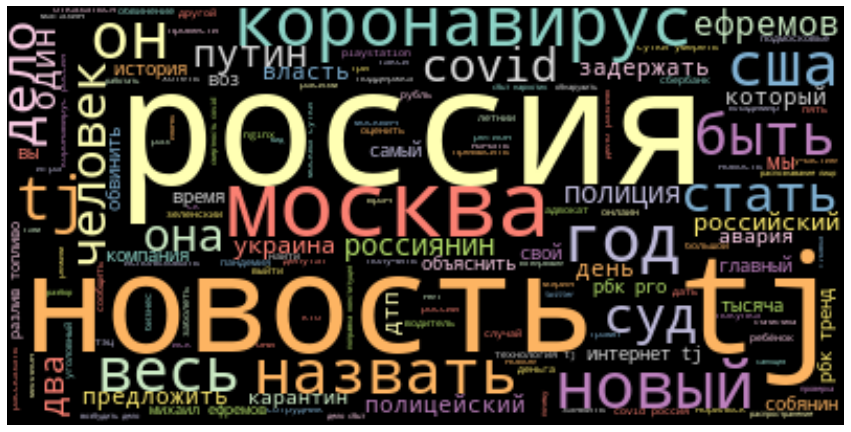

In [26]:
text = ''
for title in title_list:
    title = ' '.join(text_pipeline(title))
    text += title + ' '
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

In [27]:
group_list = [post[1] for post in posts]
group_list

['meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'kommersant_ru',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'kommersant_ru',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'kommersant_ru',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzaproject',
 'meduzapr

In [28]:
news['group'] = group_list

In [29]:
news

,title,text,title_unq,nopunc,group
0,Редакция «Ведомостей» после смены владельцев и...,Редакция «Ведомостей» рекомендовала совету дир...,"{«Ведомостей», главным, Редакция, назначить, р...",Редакция «Ведомостей» после смены владельцев и...,meduzaproject
1,Собянин попросил москвичей не ходить на парад ...,"Мэр Москвы Сергей Собянин заявил, что в День Р...","{попросил, москвичей, парад, не, ходить, Побед...",Собянин попросил москвичей не ходить на парад ...,meduzaproject
2,Курс евро на Московской бирже поднялся выше 79...,Курс евро на торгах на Московской бирже поднял...,"{на, Московской, Курс, 79, рублей, выше, евро,...",Курс евро на Московской бирже поднялся выше р...,meduzaproject
3,Хакеры взломали 300 тысяч учетных записей поль...,В результате хакерской атаки были похищены дан...,"{записей, взломали, учетных, 300, Хакеры, Nint...",Хакеры взломали тысяч учетных записей пользов...,meduzaproject
4,Бизнесмена из «списка Титова» вопреки обещания...,Хорошевский суд Москвы арестовал бывшего генди...,"{возвращения, под, посадили, из, Бизнесмена, а...",Бизнесмена из «списка Титова» вопреки обещания...,meduzaproject
...,...,...,...,...,...
571,Что ждет туристов на Черном море,В Крыму начинается курортный сезон — сначала д...,"{туристов, ждет, Черном, Что, море, на}",Что ждет туристов на Черном море,ria
572,В Алуште прокомментировали скандал с ошибкой в...,Работник городской администрации крымской Алуш...,"{на, ошибкой, В, с, скандал, слове, плакате, А...",В Алуште прокомментировали скандал с ошибкой в...,ria
573,Главе Норильска предъявили обвинение после раз...,Главе Норильска Ринату Ахметчину предъявлено о...,"{предъявили, Норильска, обвинение, Главе, посл...",Главе Норильска предъявили обвинение после раз...,ria
574,На какие технологии будущего делают ставку пот...,"3D-принтеры, микрочипы, отслеживающие здоровье...","{На, бизнес, потребители, Тренды, делают, каки...",На какие технологии будущего делают ставку пот...,rbc


In [30]:
news['likes_count'] = [post[5] for post in posts]
news['views_count'] = [post[6] for post in posts]
news['comments_count'] = [post[7] for post in posts]
news['reposts_count'] = [post[8] for post in posts]
news

,title,text,title_unq,nopunc,group,likes_count,views_count,comments_count,reposts_count
0,Редакция «Ведомостей» после смены владельцев и...,Редакция «Ведомостей» рекомендовала совету дир...,"{«Ведомостей», главным, Редакция, назначить, р...",Редакция «Ведомостей» после смены владельцев и...,meduzaproject,47,32424,11,1
1,Собянин попросил москвичей не ходить на парад ...,"Мэр Москвы Сергей Собянин заявил, что в День Р...","{попросил, москвичей, парад, не, ходить, Побед...",Собянин попросил москвичей не ходить на парад ...,meduzaproject,521,68447,104,12
2,Курс евро на Московской бирже поднялся выше 79...,Курс евро на торгах на Московской бирже поднял...,"{на, Московской, Курс, 79, рублей, выше, евро,...",Курс евро на Московской бирже поднялся выше р...,meduzaproject,82,34862,25,2
3,Хакеры взломали 300 тысяч учетных записей поль...,В результате хакерской атаки были похищены дан...,"{записей, взломали, учетных, 300, Хакеры, Nint...",Хакеры взломали тысяч учетных записей пользов...,meduzaproject,66,35133,14,1
4,Бизнесмена из «списка Титова» вопреки обещания...,Хорошевский суд Москвы арестовал бывшего генди...,"{возвращения, под, посадили, из, Бизнесмена, а...",Бизнесмена из «списка Титова» вопреки обещания...,meduzaproject,181,39505,42,8
...,...,...,...,...,...,...,...,...,...
571,Что ждет туристов на Черном море,В Крыму начинается курортный сезон — сначала д...,"{туристов, ждет, Черном, Что, море, на}",Что ждет туристов на Черном море,ria,100,48110,122,4
572,В Алуште прокомментировали скандал с ошибкой в...,Работник городской администрации крымской Алуш...,"{на, ошибкой, В, с, скандал, слове, плакате, А...",В Алуште прокомментировали скандал с ошибкой в...,ria,277,69653,179,8
573,Главе Норильска предъявили обвинение после раз...,Главе Норильска Ринату Ахметчину предъявлено о...,"{предъявили, Норильска, обвинение, Главе, посл...",Главе Норильска предъявили обвинение после раз...,ria,194,55041,155,10
574,На какие технологии будущего делают ставку пот...,"3D-принтеры, микрочипы, отслеживающие здоровье...","{На, бизнес, потребители, Тренды, делают, каки...",На какие технологии будущего делают ставку пот...,rbc,5,4411,10,1


In [33]:
news['likes_to_views'] = news['likes_count'] / news['views_count']
news['processed_title'] = [' '.join(text_pipeline(title)) for title in news['title']]
news

,title,text,title_unq,nopunc,group,likes_count,views_count,comments_count,reposts_count,likes_to_views,processed_title
0,Редакция «Ведомостей» после смены владельцев и...,Редакция «Ведомостей» рекомендовала совету дир...,"{«Ведомостей», главным, Редакция, назначить, р...",Редакция «Ведомостей» после смены владельцев и...,meduzaproject,47,32424,11,1,0.001450,редакция «ведомостей» смена владелец издание п...
1,Собянин попросил москвичей не ходить на парад ...,"Мэр Москвы Сергей Собянин заявил, что в День Р...","{попросил, москвичей, парад, не, ходить, Побед...",Собянин попросил москвичей не ходить на парад ...,meduzaproject,521,68447,104,12,0.007612,собянин попросить москвич ходить парад победа
2,Курс евро на Московской бирже поднялся выше 79...,Курс евро на торгах на Московской бирже поднял...,"{на, Московской, Курс, 79, рублей, выше, евро,...",Курс евро на Московской бирже поднялся выше р...,meduzaproject,82,34862,25,2,0.002352,курс евро московский биржа подняться выше 79 р...
3,Хакеры взломали 300 тысяч учетных записей поль...,В результате хакерской атаки были похищены дан...,"{записей, взломали, учетных, 300, Хакеры, Nint...",Хакеры взломали тысяч учетных записей пользов...,meduzaproject,66,35133,14,1,0.001879,хакер взломать 300 тысяча учётный запись польз...
4,Бизнесмена из «списка Титова» вопреки обещания...,Хорошевский суд Москвы арестовал бывшего генди...,"{возвращения, под, посадили, из, Бизнесмена, а...",Бизнесмена из «списка Титова» вопреки обещания...,meduzaproject,181,39505,42,8,0.004582,бизнесмен «список титова» обещание власть поса...
...,...,...,...,...,...,...,...,...,...,...,...
571,Что ждет туристов на Черном море,В Крыму начинается курортный сезон — сначала д...,"{туристов, ждет, Черном, Что, море, на}",Что ждет туристов на Черном море,ria,100,48110,122,4,0.002079,ждать турист чёрный мор
572,В Алуште прокомментировали скандал с ошибкой в...,Работник городской администрации крымской Алуш...,"{на, ошибкой, В, с, скандал, слове, плакате, А...",В Алуште прокомментировали скандал с ошибкой в...,ria,277,69653,179,8,0.003977,алушта прокомментировать скандал ошибка слово ...
573,Главе Норильска предъявили обвинение после раз...,Главе Норильска Ринату Ахметчину предъявлено о...,"{предъявили, Норильска, обвинение, Главе, посл...",Главе Норильска предъявили обвинение после раз...,ria,194,55041,155,10,0.003525,глава норильск предъявить обвинение разлив топ...
574,На какие технологии будущего делают ставку пот...,"3D-принтеры, микрочипы, отслеживающие здоровье...","{На, бизнес, потребители, Тренды, делают, каки...",На какие технологии будущего делают ставку пот...,rbc,5,4411,10,1,0.001134,какой технология будущее делать ставка потреби...


In [81]:
from sklearn.feature_extraction.text import CountVectorizer
print('Text len: ', len(text))
vectorizer = CountVectorizer()
vectorizer.fit([text])
print('Vocabulary len: ', len(vectorizer.vocabulary_), '\n', list(vectorizer.vocabulary_.items())[:10], sep='')

Text len:  39081
Vocabulary len: 2301
[('редакция', 1713), ('ведомостей', 300), ('смена', 1875), ('владелец', 332), ('издание', 715), ('предложить', 1532), ('назначить', 1067), ('анфис', 196), ('воронин', 360), ('главное', 444)]


In [82]:
sorted_d = {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True)}
list(sorted_d.items())[:10]

[('ясный', 2300),
 ('ясно', 2299),
 ('яндексу', 2298),
 ('яндекскуколд', 2297),
 ('яндекса', 2296),
 ('яндекс', 2295),
 ('яиц', 2294),
 ('язык', 2293),
 ('яд', 2292),
 ('ютьюбе', 2291)]

In [74]:
counts = [item[1] for item in sorted_d.items()]
print('Len: ', len(counts), '\n', counts[:10], sep='')

Len: 2301
[2300, 2299, 2298, 2297, 2296, 2295, 2294, 2293, 2292, 2291]


In [75]:
labels = [item[0] for item in sorted_d.items()]
print('Len: ', len(labels), '\n', labels[:10], sep='')

Len: 2301
['ясный', 'ясно', 'яндексу', 'яндекскуколд', 'яндекса', 'яндекс', 'яиц', 'язык', 'яд', 'ютьюбе']


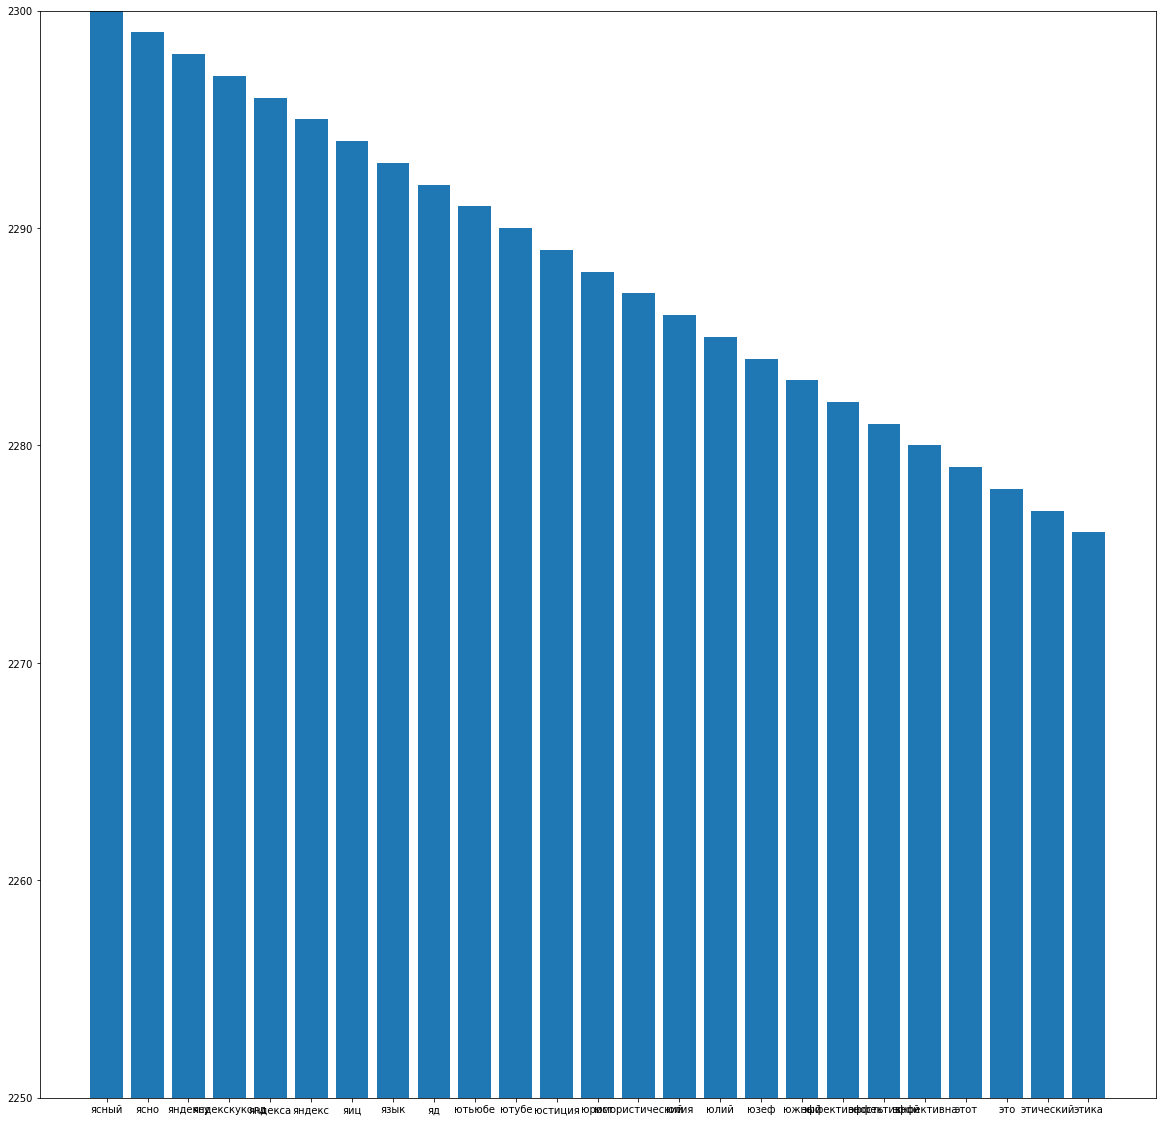

In [38]:
COUNT = 25
plt.subplots(figsize=(20,20))
plt.bar(range(len(counts[:COUNT])), counts[:COUNT])
plt.xticks(range(len(counts[:COUNT])), tuple(labels[:COUNT]))
plt.ylim(ymax = counts[0], ymin = counts[COUNT * 2])
plt.show()

In [39]:
news['title'][0]

'Редакция «Ведомостей» после смены владельцев издания предложила назначить Анфису Воронину главным редактором'

In [40]:
vectorized_title = vectorizer.transform(news['title'])
vectorized_title

<576x2301 sparse matrix of type '<class 'numpy.int64'>'
	with 2638 stored elements in Compressed Sparse Row format>

In [41]:
print(len(vectorizer.vocabulary_))

2301


In [43]:
for i, col in enumerate(vectorizer.get_feature_names()):
    news[col] = pd.Series(pd.arrays.SparseArray(vectorized_title[:, i].toarray().ravel(), fill_value=0))
news

,title,text,title_unq,nopunc,group,likes_count,views_count,comments_count,reposts_count,likes_to_views,...,ютьюбе,яд,язык,яиц,яндекс,яндекса,яндекскуколд,яндексу,ясно,ясный
0,Редакция «Ведомостей» после смены владельцев и...,Редакция «Ведомостей» рекомендовала совету дир...,"{«Ведомостей», главным, Редакция, назначить, р...",Редакция «Ведомостей» после смены владельцев и...,meduzaproject,47,32424,11,1,0.001450,...,0,0,0,0,0,0,0,0,0,0
1,Собянин попросил москвичей не ходить на парад ...,"Мэр Москвы Сергей Собянин заявил, что в День Р...","{попросил, москвичей, парад, не, ходить, Побед...",Собянин попросил москвичей не ходить на парад ...,meduzaproject,521,68447,104,12,0.007612,...,0,0,0,0,0,0,0,0,0,0
2,Курс евро на Московской бирже поднялся выше 79...,Курс евро на торгах на Московской бирже поднял...,"{на, Московской, Курс, 79, рублей, выше, евро,...",Курс евро на Московской бирже поднялся выше р...,meduzaproject,82,34862,25,2,0.002352,...,0,0,0,0,0,0,0,0,0,0
3,Хакеры взломали 300 тысяч учетных записей поль...,В результате хакерской атаки были похищены дан...,"{записей, взломали, учетных, 300, Хакеры, Nint...",Хакеры взломали тысяч учетных записей пользов...,meduzaproject,66,35133,14,1,0.001879,...,0,0,0,0,0,0,0,0,0,0
4,Бизнесмена из «списка Титова» вопреки обещания...,Хорошевский суд Москвы арестовал бывшего генди...,"{возвращения, под, посадили, из, Бизнесмена, а...",Бизнесмена из «списка Титова» вопреки обещания...,meduzaproject,181,39505,42,8,0.004582,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,Что ждет туристов на Черном море,В Крыму начинается курортный сезон — сначала д...,"{туристов, ждет, Черном, Что, море, на}",Что ждет туристов на Черном море,ria,100,48110,122,4,0.002079,...,0,0,0,0,0,0,0,0,0,0
572,В Алуште прокомментировали скандал с ошибкой в...,Работник городской администрации крымской Алуш...,"{на, ошибкой, В, с, скандал, слове, плакате, А...",В Алуште прокомментировали скандал с ошибкой в...,ria,277,69653,179,8,0.003977,...,0,0,0,0,0,0,0,0,0,0
573,Главе Норильска предъявили обвинение после раз...,Главе Норильска Ринату Ахметчину предъявлено о...,"{предъявили, Норильска, обвинение, Главе, посл...",Главе Норильска предъявили обвинение после раз...,ria,194,55041,155,10,0.003525,...,0,0,0,0,0,0,0,0,0,0
574,На какие технологии будущего делают ставку пот...,"3D-принтеры, микрочипы, отслеживающие здоровье...","{На, бизнес, потребители, Тренды, делают, каки...",На какие технологии будущего делают ставку пот...,rbc,5,4411,10,1,0.001134,...,0,0,0,0,0,0,0,0,0,0


In [44]:
news.iloc[:, 12:]

,11,12,1200,129,14,15,150,16,17,18,...,ютьюбе,яд,язык,яиц,яндекс,яндекса,яндекскуколд,яндексу,ясно,ясный
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
573,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
print('Likes: ', news[news['10']==1]['likes_count'].sum())
print('Views: ', news[news['10']==1]['views_count'].sum())
print('Comments: ', news[news['10']==1]['comments_count'].sum())
print('Reposts: ', news[news['10']==1]['reposts_count'].sum())

Likes:  308
Views:  96092
Comments:  160
Reposts:  21


In [47]:
for column in news.columns[-20:]:
    print('Word: ', column)
    print('Likes: ', news[news[column]==1]['likes_count'].sum())
    print('Views: ', news[news[column]==1]['views_count'].sum())
    print('Comments: ', news[news[column]==1]['comments_count'].sum())
    print('Reposts: ', news[news[column]==1]['reposts_count'].sum(), end='\n\n')

Word:  эффективной
Likes:  102
Views:  33014
Comments:  50
Reposts:  4

Word:  эффективность
Likes:  32
Views:  19202
Comments:  92
Reposts:  2

Word:  южный
Likes:  0
Views:  0
Comments:  0
Reposts:  0

Word:  юзеф
Likes:  0
Views:  0
Comments:  0
Reposts:  0

Word:  юлий
Likes:  0
Views:  0
Comments:  0
Reposts:  0

Word:  юлия
Likes:  0
Views:  0
Comments:  0
Reposts:  0

Word:  юмористический
Likes:  0
Views:  0
Comments:  0
Reposts:  0

Word:  юрист
Likes:  0
Views:  0
Comments:  0
Reposts:  0

Word:  юстиция
Likes:  0
Views:  0
Comments:  0
Reposts:  0

Word:  ютубе
Likes:  92
Views:  20764
Comments:  30
Reposts:  3

Word:  ютьюбе
Likes:  302
Views:  65005
Comments:  112
Reposts:  6

Word:  яд
Likes:  0
Views:  0
Comments:  0
Reposts:  0

Word:  язык
Likes:  170
Views:  75203
Comments:  210
Reposts:  3

Word:  яиц
Likes:  179
Views:  34493
Comments:  9
Reposts:  14

Word:  яндекс
Likes:  577
Views:  121173
Comments:  576
Reposts:  11

Word:  яндекса
Likes:  3
Views:  3446
Comment

In [48]:
words_df = pd.DataFrame({
        'word': [],
        'likes': [],
        'views': [],
        'comments': [],
        'reposts': []
    })
words_df

,word,likes,views,comments,reposts


In [49]:
cursor.execute('SELECT * FROM groups')
records = cursor.fetchall()
groups = list(records)
groups

[(76982440, 'meduzaproject', '«Медуза»', 713510),
 (15755094, 'ria', 'РИА Новости', 2502783),
 (23482909, 'kommersant_ru', 'Коммерсантъ', 329570),
 (28261334, 'tj', 'TJ', 702610),
 (25232578, 'rbc', 'РБК', 767864)]

In [50]:
groups_df = pd.DataFrame({
    'name': [group[2] for group in groups],
    'screen_name': [group[1] for group in groups],
    'members_count': [group[3] for group in groups]
})
groups_df

,name,screen_name,members_count
0,«Медуза»,meduzaproject,713510
1,РИА Новости,ria,2502783
2,Коммерсантъ,kommersant_ru,329570
3,TJ,tj,702610
4,РБК,rbc,767864


In [56]:
for column in news.columns[12:]:
    row = {
        'word': column,
        'likes': news[news[column]==1]['likes_count'].sum(),
        'views': news[news[column]==1]['views_count'].sum(),
        'comments': news[news[column]==1]['comments_count'].sum(),
        'reposts': news[news[column]==1]['reposts_count'].sum()
    }
    for group in groups_df.iterrows():
        row[group[1][0]] = len(news[(news[column]==1) & (news['group']==group[1][1])]) 
    words_df = words_df.append(row, ignore_index=True)
words_df

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости
0,10,300.0,90245.0,159.0,22.0,0.0,2.0,1.0,1.0,0.0
1,11,332.0,88043.0,68.0,3.0,1.0,1.0,2.0,1.0,0.0
2,12,266.0,84653.0,154.0,3.0,1.0,2.0,1.0,0.0,0.0
3,1200,100.0,25657.0,51.0,1.0,0.0,1.0,0.0,0.0,0.0
4,14,241.0,78474.0,138.0,7.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1807,яндекса,3.0,3038.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0
1808,яндекскуколд,477.0,85259.0,538.0,10.0,1.0,1.0,0.0,0.0,0.0
1809,яндексу,78.0,19850.0,35.0,1.0,0.0,0.0,1.0,1.0,0.0
1810,ясно,3.0,2451.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0


In [58]:
words_df['likes2views'] = words_df['likes'] / words_df['views']
words_df['comments2views'] = words_df['comments'] / words_df['views']
words_df

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости,likes2views,comments2views
0,10,300.0,90245.0,159.0,22.0,0.0,2.0,1.0,1.0,0.0,0.003324,0.001762
1,11,332.0,88043.0,68.0,3.0,1.0,1.0,2.0,1.0,0.0,0.003771,0.000772
2,12,266.0,84653.0,154.0,3.0,1.0,2.0,1.0,0.0,0.0,0.003142,0.001819
3,1200,100.0,25657.0,51.0,1.0,0.0,1.0,0.0,0.0,0.0,0.003898,0.001988
4,14,241.0,78474.0,138.0,7.0,0.0,2.0,0.0,0.0,0.0,0.003071,0.001759
...,...,...,...,...,...,...,...,...,...,...,...,...
1807,яндекса,3.0,3038.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000987,0.001317
1808,яндекскуколд,477.0,85259.0,538.0,10.0,1.0,1.0,0.0,0.0,0.0,0.005595,0.006310
1809,яндексу,78.0,19850.0,35.0,1.0,0.0,0.0,1.0,1.0,0.0,0.003929,0.001763
1810,ясно,3.0,2451.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.001224,0.001224


In [62]:
words_df = words_df.dropna()

In [64]:
# Most liked are news with words below in title
words_df.sort_values(by=['likes2views'], ascending=False).head(10)

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости,likes2views,comments2views
796,москвичу,598.0,45091.0,165.0,28.0,0.0,1.0,0.0,0.0,0.0,0.013262,0.003659
1733,хочешь,598.0,45091.0,165.0,28.0,0.0,1.0,0.0,0.0,0.0,0.013262,0.003659
1408,себя,599.0,48041.0,168.0,28.0,0.0,1.0,1.0,0.0,0.0,0.012469,0.003497
1072,подбросить,943.0,76000.0,258.0,43.0,1.0,1.0,0.0,0.0,0.0,0.012408,0.003395
363,громко,943.0,76000.0,258.0,43.0,1.0,1.0,0.0,0.0,0.0,0.012408,0.003395
34,720,437.0,37709.0,45.0,14.0,0.0,1.0,0.0,0.0,0.0,0.011589,0.001193
1698,фбк,437.0,37709.0,45.0,14.0,0.0,1.0,0.0,0.0,0.0,0.011589,0.001193
855,недвижимость,437.0,37709.0,45.0,14.0,0.0,1.0,0.0,0.0,0.0,0.011589,0.001193
1608,тот,345.0,30909.0,93.0,15.0,1.0,0.0,0.0,0.0,0.0,0.011162,0.003009
804,мужчине,345.0,30909.0,93.0,15.0,1.0,0.0,0.0,0.0,0.0,0.011162,0.003009


In [65]:
# Most discussed are news with words below in title
words_df.sort_values(by=['comments2views'], ascending=False).head(10)

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости,likes2views,comments2views
534,извиняться,49.0,21241.0,244.0,6.0,0.0,0.0,0.0,0.0,1.0,0.002307,0.011487
408,доля,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
226,вдвое,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
1169,почти,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
177,безусловных,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
523,знать,63.0,37498.0,401.0,8.0,0.0,0.0,0.0,2.0,0.0,0.001680,0.010694
451,жесткие,101.0,27626.0,284.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003656,0.010280
224,ввести,101.0,27626.0,284.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003656,0.010280
1167,похороны,17.0,20366.0,196.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000835,0.009624
1714,фоторепортаж,17.0,20366.0,196.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000835,0.009624


In [71]:
words_df[['likes', 'comments', 'reposts', 'views']].corr()

,likes,comments,reposts,views
likes,1.000000,0.903448,0.943461,0.977955
comments,0.903448,1.000000,0.938303,0.908972
reposts,0.943461,0.938303,1.000000,0.928201
views,0.977955,0.908972,0.928201,1.000000
